# Robinson Crusoe or how to build your own model

With ``respy`` you are able to prototype a model similar to Keane and Wolpin (1997) in minutes. In this notebook we will implement a model of a common theme in economics - the Robinson Crusoe economy - as a discrete choice dynamic programming model. Throughout the notebook you find indented text which tell parts of Robinson's story and motivate the model.

In [1]:
%matplotlib inline

import io
import matplotlib.pyplot as plt
import pandas as pd
import respy as rp
import yaml
import seaborn as sns

from pathlib import Path
from time import time

## Introduction

> After setting sail against his parents wishes, being captured by pirates, escaping from them, building a plantation and setting sail again to capture slaves in Africa, [Robinson Crusoe](https://en.wikipedia.org/wiki/Robinson_Crusoe) stranded on a small island. He is alone with one dog, two cats and only some supplies. To make ends meet he goes fishing and if he is too tired he will relax in his hammock made of old canvas.

The core assumption of discrete choice dynamic programming models is that individuals maximize the expected present value of utility over all choices. This is what guides indivduals to choose different actions in each period. In the example of Robinson Crusoe,

In [2]:
%%writefile robinson-crusoe.csv

category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_hammock,constant,3
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,-0.2
meas_error,sd_fishing,1e-6
lagged_choice_1_hammock,constant,1

Overwriting robinson-crusoe.csv


In [3]:
%%writefile robinson-crusoe.yaml

estimation_draws: 10000
estimation_seed: 500
estimation_tau: 50
interpolation_points: -1
n_periods: 10
simulation_agents: 1000
simulation_seed: 132
solution_draws: 10000
solution_seed: 456
covariates:
    constant: "1"
    not_fishing_last_period: "lagged_choice_1 != 'fishing'"

Overwriting robinson-crusoe.yaml


In [4]:
params = pd.read_csv("robinson-crusoe.csv", index_col=["category", "name"])
options = yaml.safe_load(Path("robinson-crusoe.yaml").read_text())

In [5]:
params

value
category                name                             
delta                   delta                    0.950000
wage_fishing            exp_fishing              0.100000
nonpec_hammock          constant                 3.000000
                        not_fishing_last_period -1.000000
shocks_sdcorr           sd_fishing               1.000000
                        sd_hammock               1.000000
                        corr_hammock_fishing    -0.200000
meas_error              sd_fishing               0.000001
lagged_choice_1_hammock constant                 1.000000

In [6]:
options

{'estimation_draws': 10000,
 'estimation_seed': 500,
 'estimation_tau': 50,
 'interpolation_points': -1,
 'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 10000,
 'solution_seed': 456,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}}

In [7]:
simulate = rp.get_simulate_func(params, options)

In [8]:
df = simulate(params)

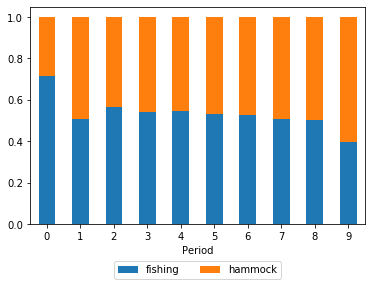

In [9]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=2)

plt.show()
plt.close()

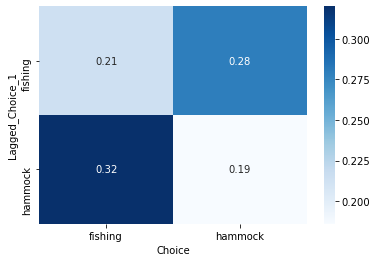

In [10]:
data = pd.crosstab(df.Lagged_Choice_1, df.Choice, normalize=True)
sns.heatmap(data, cmap="Blues", annot=True)

## A small extension

> At some point Crusoe notices that a group of cannibals occasionally visits the island and celebrate one of their dark rituals. But then, a prisoner can escape and becomes Crusoe's new friend Friday whom he teaches English. In return Friday can share his knowledge once to help Robinson improve his fishing skills, but that is only possible after Robinson tried at least once to go fishing.

- show that there are two possible ways to implement Friday, experience and lagged_choice
- show that there are two possible ways to restrict talking to Friday to a one-time choice

In [8]:
%%writefile robinson-crusoe.csv

category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
wage_fishing,contemplation_with_friday,0.3
nonpec_friday,constant,-1
nonpec_friday,no_exp_fishing,-99
nonpec_hammock,constant,2
shocks,sd_fishing,1
shocks,sd_friday,1
shocks,sd_hammock,1
shocks,corr_friday_fishing,0
shocks,corr_hammock_fishing,-0.2
shocks,corr_hammock_friday,0
meas_error,sd_fishing,0.1

Overwriting robinson-crusoe.csv


In [9]:
%%writefile robinson-crusoe.yaml

estimation_draws: 10000
estimation_seed: 500
estimation_tau: 50
interpolation_points: -1
n_periods: 10
simulation_agents: 1000
simulation_seed: 132
solution_draws: 10000
solution_seed: 456
covariates:
    constant: "1"
    contemplation_with_friday: "exp_friday == 1 and exp_fishing >= 1"
    no_exp_fishing: "exp_fishing == 0"

Overwriting robinson-crusoe.yaml


In [10]:
simulate = rp.get_simulate_func(params, options)

In [11]:
df = simulate(params)

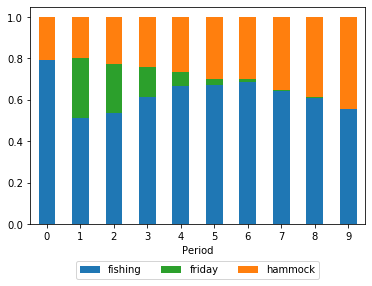

In [15]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax, color=["C0", "C2", "C1"],
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=3)

plt.show()
plt.close()

In [13]:
asdasdsa

NameError: name 'asdasdsa' is not defined

## Changing the utility function

- implement a log utility function
- try to patch the other function over at runtime https://medium.com/@chipiga86/python-monkey-patching-like-a-boss-87d7ddb8098e

In [ ]:
@nb.njit
def log_utility(wage, nonpec, continuation_value, draw, delta, is_inadmissible):
    flow_utility = wage * draw + nonpec
    value_function = flow_utility + delta * continuation_value

    if is_inadmissible:
        value_function += INADMISSIBILITY_PENALTY

    return value_function, flow_utility

## Estimate parameters

In [ ]:
criterion = rp.get_crit_func(params, options, df)

In [ ]:
start = time()
criterion(params)
end = time()

print(f"One evaluation of the likelihood took {end - start:.2f} seconds.")

In [ ]:
import numpy as np
from estimagic.optimization.optimize import maximize

In [ ]:
constr = [{"loc": "shocks", "type": "sdcorr", 'bounds_distance' : 1e-15}, {"loc": "delta", "type": "fixed"}]

In [ ]:
params = pd.read_csv(params, index_col=["category", "name"])

params["group"] = params.index.get_level_values('category')
params['lower'] = -np.inf
params['upper'] = np.inf
params

In [ ]:
results, params = maximize(criterion, params, "nlopt_neldermead", db_options={"rollover": 200}, algo_options={"maxeval": 100}, constraints=constr, dashboard=True)

In [ ]:
results